已保存：summary_missing.csv / .md / .tex


,method,N,RMSE,EndErr,Jerk,Trainms,Inferms
0,ProMP,96.0,0.783 ± 0.452,0.743 ± 0.544,**32630.790 ± 11715.980**,1.990 ± 0.424,1.568 ± 3.721
1,GP,96.0,**0.762 ± 0.452**,0.575 ± 0.312,44140.476 ± 16273.493,2.882 ± 0.857,**0.795 ± 0.209**
2,KMP,96.0,0.907 ± 0.434,0.575 ± 0.312,37860.605 ± 12914.634,**0.884 ± 0.457**,1.254 ± 3.682
3,U-KMP,96.0,1.304 ± 0.778,**0.575 ± 0.312**,45669.243 ± 17437.227,0.884 ± 0.457,1.107 ± 3.630


已保存：summary_obstacle.csv / .md / .tex


,method,N,RMSE,EndErr,Jerk,Trainms,Inferms
0,GP,48.0,**1.541 ± 0.547**,0.722 ± 0.532,**22790.299 ± 6719.954**,**1.372 ± 0.508**,**0.576 ± 0.151**
1,KMP,41.0,1.616 ± 0.540,**0.672 ± 0.394**,25549.189 ± 6234.090,,
2,U-KMP,41.0,1.616 ± 0.540,0.672 ± 0.394,25549.380 ± 6234.053,,


已保存：summary_reproduction.csv / .md / .tex


,method,N,RMSE,EndErr,Jerk,Trainms,Inferms
0,DMP,99.0,9.243 ± 5.881,4.472 ± 6.248,**14216.098 ± 15675.840**,0.920 ± 1.773,3.589 ± 3.774
1,ProMP,48.0,1.216 ± 0.625,0.579 ± 0.320,19625.164 ± 7251.281,3.049 ± 2.225,**0.033 ± 0.026**
2,GP,48.0,1.215 ± 0.627,0.575 ± 0.314,22442.444 ± 7492.333,**0.009 ± 0.005**,737.553 ± 220.903
3,KMP,96.0,1.215 ± 0.624,**0.575 ± 0.312**,22153.010 ± 7337.120,0.264 ± 0.193,3.162 ± 1.164
4,U-KMP,96.0,**1.215 ± 0.624**,0.575 ± 0.312,22169.547 ± 7338.068,0.264 ± 0.193,3.072 ± 0.766


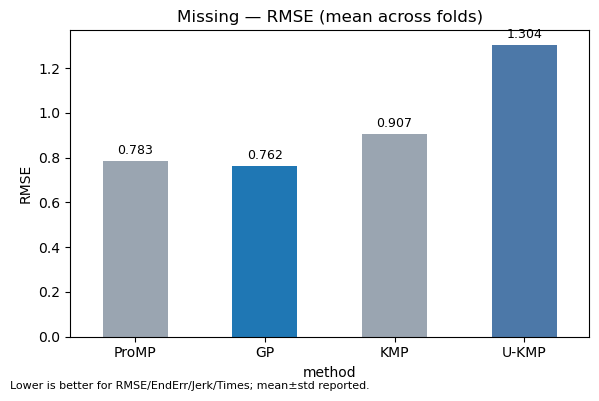

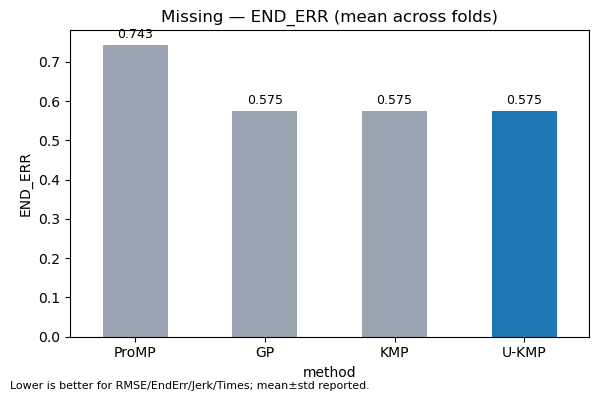

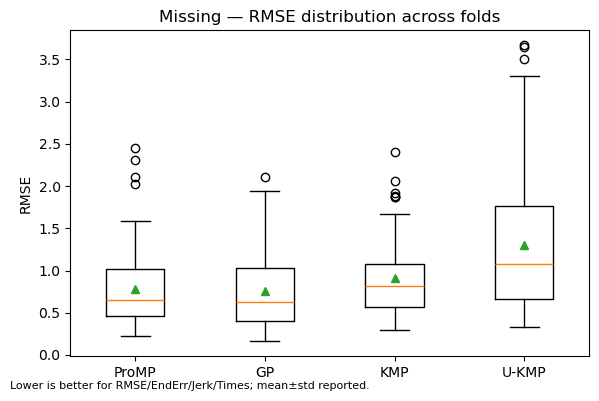

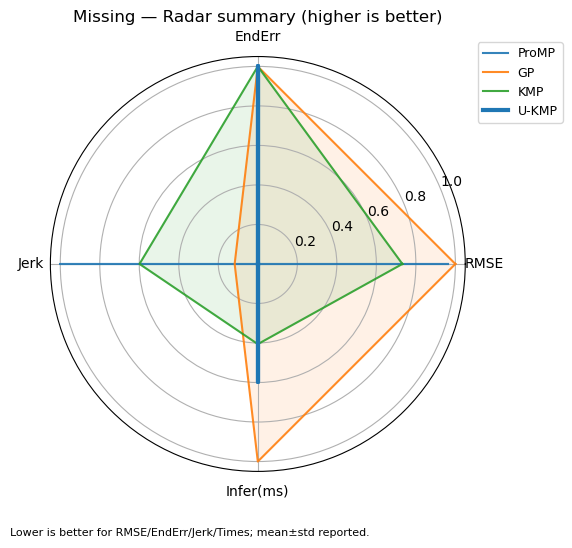

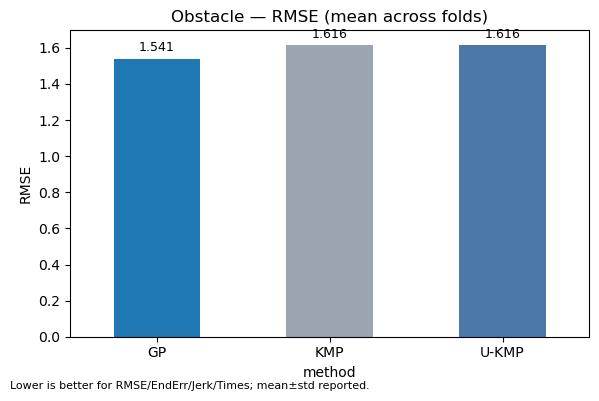

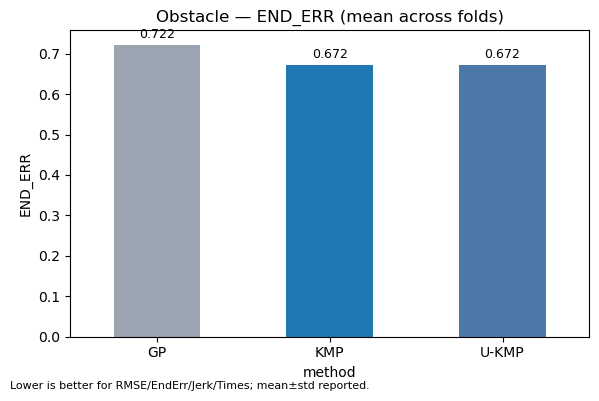

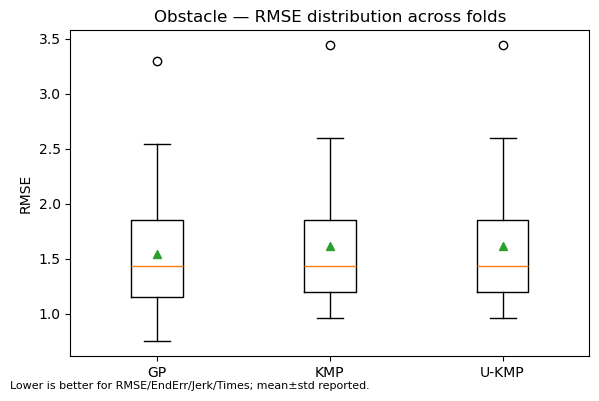

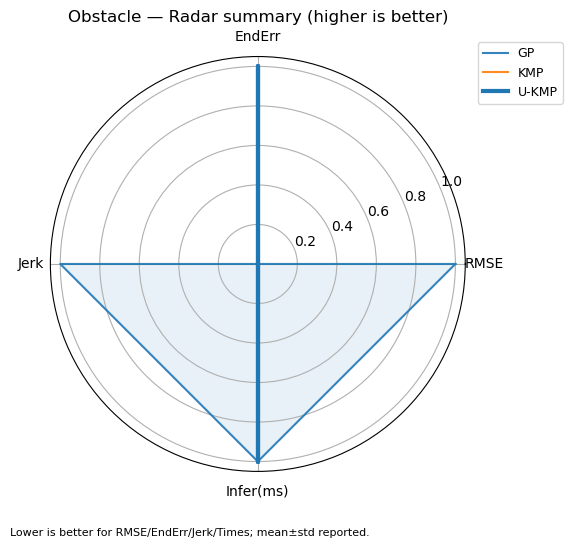

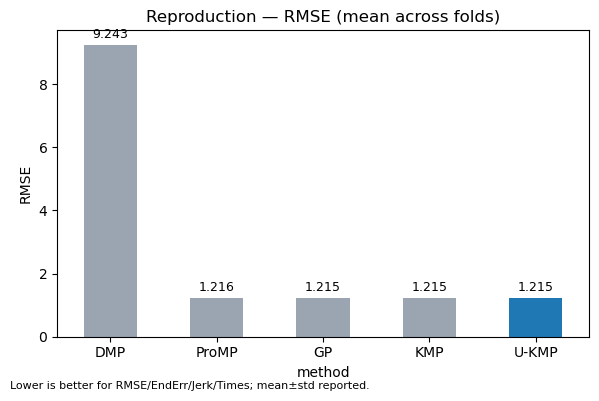

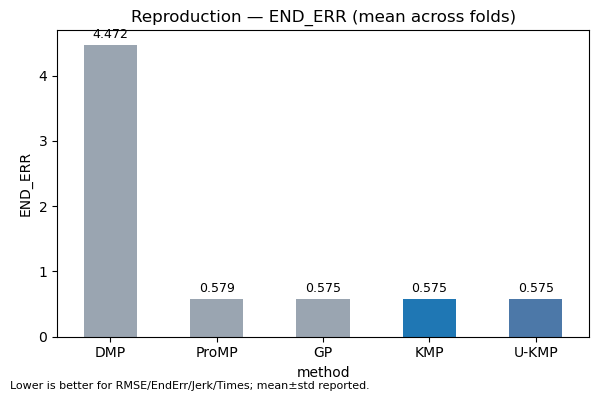

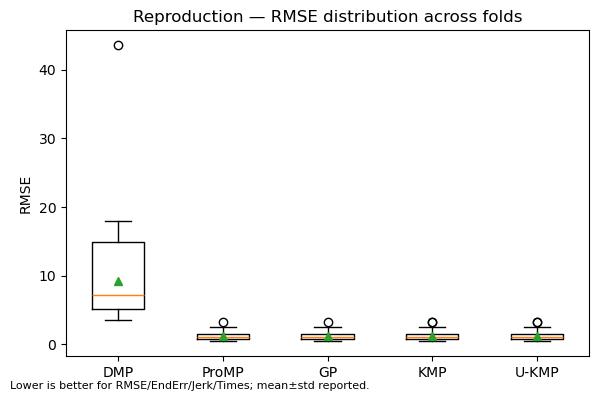

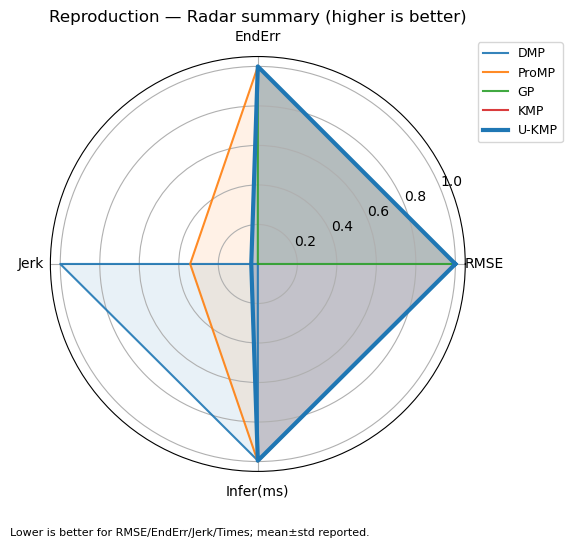

完成：已在 results/ 产出 summary_*.csv / .md / .tex；在 figs/ 产出 bar_*.png / box_*.png / radar_*.png（dpi=300）


In [27]:
# ===================== results_summary (U-KMP 高亮 + 最优加粗 版) =====================
import warnings
warnings.filterwarnings("ignore")

import os, glob, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
# 目录
os.makedirs('results', exist_ok=True)
os.makedirs('figs', exist_ok=True)

# 固定显示顺序 & 高亮对象
METHOD_ORDER = ['DMP','ProMP','GP','KMP','U-KMP']
HIGHLIGHT_METHOD = 'U-KMP'
DPI = 300

# ---------------- 1) 读取 CSV & 标准化 ----------------
def guess_experiment(fname: str):
    f = os.path.basename(fname).lower()
    if 'missing'  in f: return 'missing'
    if 'obstacle' in f: return 'obstacle'
    return 'reproduction'

def std_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    alias = {'end':'end_err','end_error':'end_err','endpoint':'end_err','endpoint_err':'end_err',
             'train':'train_ms','infer':'infer_ms','time_train':'train_ms','time_infer':'infer_ms'}
    for a,b in alias.items():
        if a in df.columns and b not in df.columns:
            df.rename(columns={a:b}, inplace=True)
    keep = ['method','letter','fold','rmse','end_err','jerk','train_ms','infer_ms']
    for k in keep:
        if k not in df.columns: df[k] = np.nan
    return df[keep]

all_rows = []
csv_files = sorted(glob.glob('results/*.csv'))
if not csv_files:
    raise FileNotFoundError("没有在 ./results 下找到任何 CSV。请先运行各方法实验以生成 CSV。")

for f in csv_files:
    try:
        t = pd.read_csv(f)
    except Exception:
        t = pd.read_csv(f, header=None, names=['method','letter','fold','rmse','end_err','jerk','train_ms','infer_ms'])
    t = std_columns(t)
    t['experiment'] = guess_experiment(f)
    t['method'] = (t['method'].astype(str).str.strip().str.upper()
                   .replace({'PROMP':'ProMP','DMP':'DMP','KMP':'KMP','U-KMP':'U-KMP',
                             'UKMP':'U-KMP','GP':'GP','GPR':'GP'}))
    all_rows.append(t)

data = pd.concat(all_rows, ignore_index=True)
for c in ['rmse','end_err','jerk','train_ms','infer_ms']:
    data[c] = pd.to_numeric(data[c], errors='coerce')
data = data.replace([np.inf,-np.inf], np.nan).dropna(subset=['rmse'])

# ---------------- 2) 异常值过滤（IQR + 绝对阈值） ----------------
def drop_outliers_block(df, cols=('rmse','end_err'), iqr_k=3.0, hard_cap=None):
    hard_cap = hard_cap or {}
    keep = np.ones(len(df), dtype=bool)
    for exp in df['experiment'].unique():
        msk_e = (df['experiment']==exp)
        for m in df.loc[msk_e,'method'].dropna().unique():
            msk_em = msk_e & (df['method']==m)
            for c in cols:
                x = pd.to_numeric(df.loc[msk_em, c], errors='coerce')
                if x.dropna().empty: continue
                q1,q3 = np.nanpercentile(x,[25,75]); iqr = q3-q1 if np.isfinite(q3-q1) else 0.0
                lo = q1 - iqr_k*iqr; hi = q3 + iqr_k*iqr
                if c in hard_cap: hi = min(hi, hard_cap[c])
                good = (x>=lo) & (x<=hi)
                keep[msk_em] &= good.fillna(False).values
    return df.loc[keep].copy()

data = drop_outliers_block(data, ('rmse','end_err'), iqr_k=3.0, hard_cap={'rmse':1e3,'end_err':1e3})

# ---------------- 3) 汇总（均值±标准差）+ 论文表导出 ----------------
def fmt_pm(m, s):
    if pd.isna(m): return ''
    if pd.isna(s) or s==0: return f'{m:.3f}'
    return f'{m:.3f} ± {s:.3f}'

def mean_std_table(df: pd.DataFrame):
    if df.empty: return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    df = df.copy()
    df['method'] = pd.Categorical(df['method'], categories=METHOD_ORDER, ordered=True)
    g = df.groupby('method', dropna=True, observed=True)

    def agg(x):
        return pd.Series({
            'RMSE_mean':x['rmse'].mean(),'RMSE_std':x['rmse'].std(),
            'End_mean':x['end_err'].mean(),'End_std':x['end_err'].std(),
            'Jerk_mean':x['jerk'].mean(),'Jerk_std':x['jerk'].std(),
            'Train_ms_mean':x['train_ms'].mean(),'Train_ms_std':x['train_ms'].std(),
            'Infer_ms_mean':x['infer_ms'].mean(),'Infer_ms_std':x['infer_ms'].std(),
            'N':len(x)
        })
    out = g.apply(agg).reset_index()

    # 纯数值表（给 CSV）
    pretty = out[['method','N']].copy()
    pretty['RMSE']    = [fmt_pm(m,s) for m,s in zip(out['RMSE_mean'], out['RMSE_std'])]
    pretty['EndErr']  = [fmt_pm(m,s) for m,s in zip(out['End_mean'],  out['End_std'])]
    pretty['Jerk']    = [fmt_pm(m,s) for m,s in zip(out['Jerk_mean'], out['Jerk_std'])]
    pretty['Trainms'] = [fmt_pm(m,s) for m,s in zip(out['Train_ms_mean'], out['Train_ms_std'])]
    pretty['Inferms'] = [fmt_pm(m,s) for m,s in zip(out['Infer_ms_mean'], out['Infer_ms_std'])]
    pretty = pretty.sort_values('method')

    # 论文表（Markdown/LaTeX）— 对每个指标最优（最小）加粗
    best = {}
    for key, col in [('RMSE','RMSE_mean'),('EndErr','End_mean'),
                     ('Jerk','Jerk_mean'),('Trainms','Train_ms_mean'),('Inferms','Infer_ms_mean')]:
        ser = out.set_index('method')[col].dropna()
        if ser.empty: best[key] = None
        else: best[key] = ser.idxmin()

    def bold_if_best(row, colkey):
        val = row[colkey]
        if pd.isna(val) or val=='' or best[colkey] is None: return val
        return f'**{val}**' if row['method']==best[colkey] else val

    md = pretty.copy()
    for k in ['RMSE','EndErr','Jerk','Trainms','Inferms']:
        md[k] = md.apply(lambda r: bold_if_best(r, k), axis=1)

    # LaTeX：把 **x** 转为 \textbf{x}
    tex = md.replace({r'\*\*(.+?)\*\*': r'\\textbf{\1}'}, regex=True)

    # 隐藏 N==0 的行（如果有占位）
    pretty = pretty[pretty['N']>0].copy()
    md     = md[md['N']>0].copy()
    tex    = tex[tex['N']>0].copy()

    return out, pretty, md, tex

experiments = sorted(data['experiment'].unique())
summary_dict = {}

for exp in experiments:
    df_e = data[data['experiment']==exp]
    raw, pretty, md, tex = mean_std_table(df_e)
    summary_dict[exp] = (raw, pretty)

    pretty.to_csv(f'results/summary_{exp}.csv', index=False)
    md.to_markdown(open(f'results/summary_{exp}.md','w',encoding='utf-8'), index=False)
    tex.to_latex(open(f'results/summary_{exp}.tex','w',encoding='utf-8'), index=False, escape=False)

    print(f'已保存：summary_{exp}.csv / .md / .tex')
    display(md)  # Notebook 中显示加粗版

# ---------------- 4) 绘图（柱 / 箱 / 雷达，高亮 U-KMP） ----------------
def _footnote():
    plt.gcf().text(0.01, 0.01,
        'Lower is better for RMSE/EndErr/Jerk/Times; mean±std reported.',
        fontsize=8, ha='left', va='bottom'
    )

def bar_compare(exp, metric='rmse'):
    df_e = data[data['experiment']==exp].copy()
    if df_e.empty or df_e[metric].dropna().empty:
        print(f'{exp}/{metric} 无数据，跳过柱状图'); return
    df_e['method'] = pd.Categorical(df_e['method'], categories=METHOD_ORDER, ordered=True)
    m = df_e.groupby('method')[metric].mean().dropna()
    if m.empty: print(f'{exp}/{metric} 无数据，跳过柱状图'); return

    # 找最优（最小）方法
    best_m = m.idxmin()
    cols = []
    for meth in m.index:
        if meth == best_m:
            cols.append('#1f77b4')        # 最优：高亮蓝
        elif meth == HIGHLIGHT_METHOD:
            cols.append('#4c78a8')        # U-KMP：次高亮
        else:
            cols.append('#9aa5b1')        # 其它：灰
    ax = m.plot(kind='bar', color=cols, figsize=(6,4))
    for p, val in zip(ax.patches, m.values):
        ax.annotate(f'{val:.3f}', (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=9, rotation=0, xytext=(0,3), textcoords='offset points')
    plt.ylabel(metric.upper())
    plt.title(f'{exp.capitalize()} — {metric.upper()} (mean across folds)')
    plt.xticks(rotation=0)
    _footnote()
    plt.tight_layout()
    plt.savefig(f'figs/bar_{exp}_{metric}.png', dpi=DPI)
    plt.show()

def boxplot_compare(exp, metric='rmse'):
    df_e = data[data['experiment']==exp].copy()
    df_e['method'] = pd.Categorical(df_e['method'], categories=METHOD_ORDER, ordered=True)
    methods = [m for m in METHOD_ORDER if m in df_e['method'].dropna().unique().tolist()]
    vals, labels = [], []
    for m in methods:
        v = df_e[df_e['method']==m][metric].dropna().values
        if len(v)>0:
            vals.append(v); labels.append(m)
    if not vals: print(f'{exp}/{metric} 无数据，跳过箱线图'); return
    plt.figure(figsize=(6,4))
    plt.boxplot(vals, labels=labels, showmeans=True)
    plt.ylabel(metric.upper())
    plt.title(f'{exp.capitalize()} — {metric.upper()} distribution across folds')
    _footnote()
    plt.tight_layout()
    plt.savefig(f'figs/box_{exp}_{metric}.png', dpi=DPI)
    plt.show()

def radar_compare(exp):
    raw, _ = summary_dict.get(exp, (pd.DataFrame(), pd.DataFrame()))
    if raw.empty:
        print(f'{exp} 无数据，跳过雷达图'); return
    M = raw[['method','RMSE_mean','End_mean','Jerk_mean','Infer_ms_mean']].copy()
    M.columns = ['method','rmse','end','jerk','infer']
    M['method'] = pd.Categorical(M['method'], categories=METHOD_ORDER, ordered=True)
    M = M.sort_values('method')

    # 归一化（小→大好）
    for c in ['rmse','end','jerk','infer']:
        v = M[c].values
        lo, hi = np.nanmin(v), np.nanmax(v)
        M[c] = 1.0 if math.isclose(hi, lo) else 1.0 - (v - lo)/(hi - lo)

    labels = ['RMSE','EndErr','Jerk','Infer(ms)']
    K = len(labels)
    ang = np.linspace(0, 2*np.pi, K, endpoint=False).tolist(); ang += ang[:1]

    plt.figure(figsize=(5.8,5.8))
    ax = plt.subplot(111, polar=True)
    for _, r in M.iterrows():
        vals = r[['rmse','end','jerk','infer']].tolist(); vals += vals[:1]
        if r['method'] == HIGHLIGHT_METHOD:
            ax.plot(ang, vals, linewidth=3, label=r['method'], color='#1f77b4')
            ax.fill(ang, vals, alpha=0.25, color='#1f77b4')
        else:
            ax.plot(ang, vals, linewidth=1.5, label=r['method'], alpha=0.9)
            ax.fill(ang, vals, alpha=0.10)
    ax.set_thetagrids(np.degrees(ang[:-1]), labels)
    ax.set_title(f'{exp.capitalize()} — Radar summary (higher is better)')
    ax.grid(True)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.05), fontsize=9)
    _footnote()
    plt.tight_layout()
    plt.savefig(f'figs/radar_{exp}.png', dpi=DPI, bbox_inches='tight')
    plt.show()

# 逐实验画图
for exp in experiments:
    bar_compare(exp, 'rmse')
    bar_compare(exp, 'end_err')
    boxplot_compare(exp, 'rmse')
    radar_compare(exp)

print("完成：已在 results/ 产出 summary_*.csv / .md / .tex；在 figs/ 产出 bar_*.png / box_*.png / radar_*.png（dpi=300）")
# ===================== end =====================

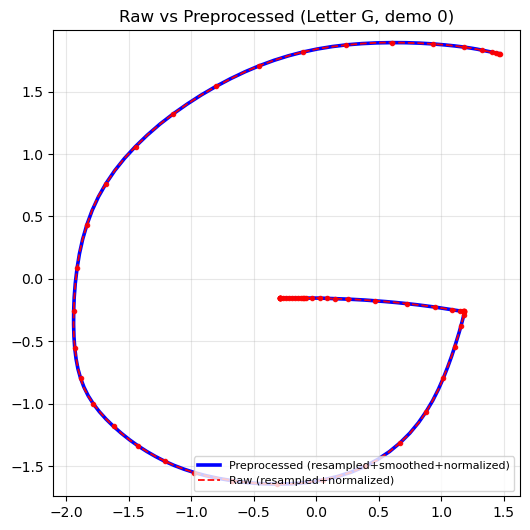

Saved: figs\preprocess_overlay_xy_G_0.png


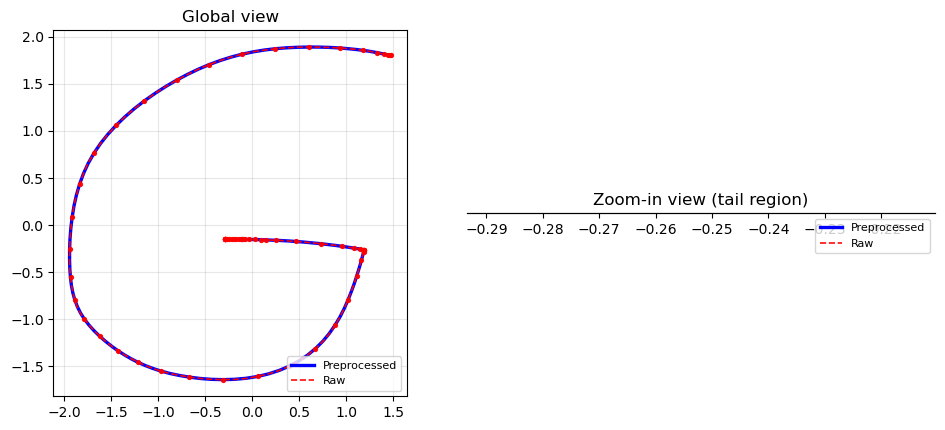

Saved: figs\preprocess_zoom_xy_G_0.png


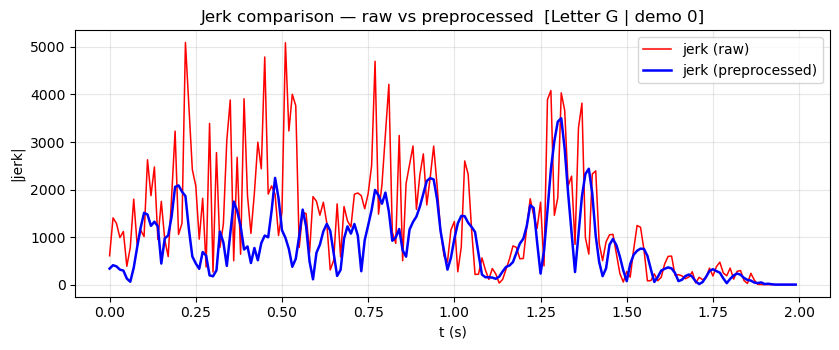

Saved: figs\preprocess_jerk_compare_G_0.png

==== Preprocessing Benefit (numbers you can cite in §4.2) ====
jerk_rms_raw: 1786.444940
jerk_rms_pp : 1104.682163
jerk_rms_drop(%): 38.16
vx_std_raw : 5.722133 | vx_std_pp : 5.716421
vy_std_raw : 4.284432 | vy_std_pp : 4.281045
ax_std_raw : 48.832839 | ax_std_pp : 46.804709
ay_std_raw : 36.688835 | ay_std_pp : 35.291417
Saved figs: figs\preprocess_overlay_xy_G_0.png figs\preprocess_zoom_xy_G_0.png figs\preprocess_jerk_compare_G_0.png


In [23]:
# ========= Raw vs Preprocessed 可复现实验图（独立可运行） =========
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

# ---------- 可调参数 ----------
letter    = 'G'        # 选择字母: 'A','B','G','H', ...
mat_path  = f'../2Dletters/{letter}.mat'   # 修改为你的路径
demo_idx  = 0          # 第 demo_idx 条演示（从 0 开始）
T         = 200        # 重采样后的统一长度
dt0       = 0.01       # 原始采样时间间隔的近似值（秒），只用于生成原始时间轴
sg_window = 11         # Savitzky–Golay 滤波窗口(奇数)，<=T-1
sg_poly   = 3          # Savitzky–Golay 多项式阶数
smooth_on = True       # 是否对重采样后轨迹平滑
norm_mode = 'zscore'   # 归一化方式：'zscore'或'minmax'或'none'
save_dir  = 'figs'     # 图片输出目录
os.makedirs(save_dir, exist_ok=True)

# ---------- 工具函数 ----------
def robust_pos_2xT_from_mat(m, demo_idx=0):
    """
    从 loadmat 结果中稳健提取 pos -> (2,T) ndarray
    兼容 demos[i].pos / demos['pos'][i] 等多种嵌套结构
    """
    demos = m['demos']
    try:
        pos_raw = demos[demo_idx].pos
    except Exception:
        pos_raw = demos['pos'][demo_idx]
    a = np.asarray(pos_raw)
    while a.dtype == object and a.size == 1:
        a = np.asarray(a.item())
    a = np.squeeze(a)
    if a.ndim != 2:
        ax = [i for i, s in enumerate(a.shape) if s == 2]
        if not ax:
            raise ValueError(f'Unexpected pos shape: {a.shape}')
        a = np.moveaxis(a, ax[0], 0).reshape(2, -1)
    else:
        if a.shape[0] == 2:
            pass
        elif a.shape[1] == 2:
            a = a.T
        else:
            raise ValueError(f'Unexpected pos shape: {a.shape}')
    return np.asarray(a, dtype=np.float64)

def resample_traj(t, pos, T=200):
    t = np.asarray(t).reshape(-1)
    t0, t1 = float(t[0]), float(t[-1])
    t_rs = np.linspace(t0, t1, T)
    pos_rs = np.zeros((pos.shape[0], T))
    for d in range(pos.shape[0]):
        f = interp1d(t, pos[d], kind='linear', fill_value='extrapolate', assume_sorted=True)
        pos_rs[d] = f(t_rs)
    dt = (t1 - t0) / (T - 1) if T > 1 else 1.0
    return t_rs, pos_rs, dt

def smooth_traj(pos, window=11, poly=3):
    if (window % 2 == 0) or (window >= pos.shape[1]):
        return pos.copy()
    out = np.zeros_like(pos)
    for d in range(pos.shape[0]):
        out[d] = savgol_filter(pos[d], window_length=window, polyorder=poly, mode='interp')
    return out

def normalize(pos, mode='zscore'):
    if mode == 'zscore':
        mean = pos.mean(axis=1, keepdims=True)
        std  = pos.std(axis=1, keepdims=True) + 1e-8
        pos_n = (pos - mean) / std
        stats = {'mode':'zscore', 'mean':mean, 'std':std}
    elif mode == 'minmax':
        mn = pos.min(axis=1, keepdims=True)
        mx = pos.max(axis=1, keepdims=True)
        rng = (mx - mn) + 1e-8
        pos_n = (pos - mn) / rng * 2.0 - 1.0
        stats = {'mode':'minmax', 'min':mn, 'max':mx}
    else:
        pos_n = pos.copy()
        stats = {'mode':'none'}
    return pos_n, stats

def denormalize(pos_n, stats):
    m = stats.get('mode', 'none')
    if m == 'zscore':
        return pos_n * stats['std'] + stats['mean']
    if m == 'minmax':
        return (pos_n + 1.0) * (stats['max'] - stats['min']) / 2.0 + stats['min']
    return pos_n

def derivs(pos, dt):
    vel = np.gradient(pos, axis=1) / dt
    acc = np.gradient(vel, axis=1) / dt
    jerk = np.gradient(acc, axis=1) / dt
    return vel, acc, jerk

def preprocess_trajectory(pos_raw, T=200, dt0=0.01,
                          smooth=True, win=11, poly=3, norm='zscore'):
    L = pos_raw.shape[1]
    t_raw = np.linspace(0.0, dt0 * (L - 1), L)
    t_rs, pos_rs, dt = resample_traj(t_raw, pos_raw, T=T)
    pos_sm = smooth_traj(pos_rs, window=win, poly=poly) if smooth else pos_rs
    pos_n, stats = normalize(pos_sm, mode=norm)
    vel_n, acc_n, jerk_n = derivs(pos_n, dt)
    return {'t': t_rs, 'dt': dt, 'pos': pos_n, 'vel': vel_n, 'acc': acc_n,
            'jerk': jerk_n, 'pos_raw_rs': pos_rs, 'stats': stats}

# ---------- 载入数据并处理 ----------
m = loadmat(mat_path, struct_as_record=False, squeeze_me=True)
pos_raw = robust_pos_2xT_from_mat(m, demo_idx=demo_idx)         # (2, L)

# 原始时间轴 + 重采样（用于“raw resampled normalized”）
L_raw = pos_raw.shape[1]
t_raw = np.linspace(0.0, dt0*(L_raw-1), L_raw)
t_rs, pos_raw_rs, dt_rs = resample_traj(t_raw, pos_raw, T=T)     # (2, T)

# Raw 的“重采样 + 归一化”（不平滑），用作对比基准
pos_raw_norm, stats_raw = normalize(pos_raw_rs, mode=norm_mode)

# 预处理（重采样 + 可选平滑 + 归一化）
prep = preprocess_trajectory(pos_raw, T=T, dt0=dt0,
                             smooth=smooth_on, win=sg_window, poly=sg_poly, norm=norm_mode)

# ---------- 1) 图①：Raw vs Preprocessed（同一坐标系：均为 normalized） ----------
plt.figure(figsize=(5.4, 5.4))
plt.plot(prep['pos'][0],     prep['pos'][1],     'b-',  lw=2.6,
         label='Preprocessed (resampled+smoothed+normalized)')
plt.plot(pos_raw_norm[0],    pos_raw_norm[1],    'r--', lw=1.3, alpha=0.95,
         label='Raw (resampled+normalized)')
plt.plot(pos_raw_norm[0,::3],pos_raw_norm[1,::3],'ro', ms=3.0, alpha=0.9)

plt.axis('equal'); plt.grid(True, alpha=0.3)
plt.title(f'Raw vs Preprocessed (Letter {letter}, demo {demo_idx})')
plt.legend(loc='lower right', fontsize=8)

# 选一个“尾段”窗口作为放大区域（后 15% 点的包围盒）
k0 = int(0.85 * T)
xwin = (prep['pos'][0, k0:].min(), prep['pos'][0, k0:].max())
ywin = (prep['pos'][1, k0:].min(), prep['pos'][1, k0:].max())
rect = plt.Rectangle((xwin[0], ywin[0]), xwin[1]-xwin[0], ywin[1]-ywin[0],
                     fill=False, ls='--', lw=1.3, ec='k')
plt.gca().add_patch(rect)
plt.tight_layout()
f1 = os.path.join(save_dir, f'preprocess_overlay_xy_{letter}_{demo_idx}.png')
plt.savefig(f1, dpi=220); plt.show()
print('Saved:', f1)

# ---------- 2) 图②：Global + Zoom（同一坐标系：normalized） ----------
fig, axes = plt.subplots(1, 2, figsize=(10, 4.4))

# Global
axg = axes[0]
axg.plot(prep['pos'][0],  prep['pos'][1],  'b-', lw=2.4, label='Preprocessed')
axg.plot(pos_raw_norm[0], pos_raw_norm[1], 'r--', lw=1.2, alpha=0.95, label='Raw')
axg.plot(pos_raw_norm[0,::3], pos_raw_norm[1,::3], 'ro', ms=2.8, alpha=0.9)
axg.add_patch(plt.Rectangle((xwin[0], ywin[0]), xwin[1]-xwin[0], ywin[1]-ywin[0],
                            fill=False, ls='--', lw=1.2, ec='k'))
axg.set_title('Global view'); axg.set_aspect('equal')
axg.grid(True, alpha=0.3); axg.legend(fontsize=8, loc='lower right')

# Zoom
axz = axes[1]
axz.plot(prep['pos'][0],  prep['pos'][1],  'b-', lw=2.4, label='Preprocessed')
axz.plot(pos_raw_norm[0], pos_raw_norm[1], 'r--', lw=1.2, alpha=0.95, label='Raw')
axz.set_xlim(xwin[0], xwin[1]); axz.set_ylim(ywin[0], ywin[1])
axz.set_title('Zoom-in view (tail region)'); axz.set_aspect('equal')
axz.grid(True, alpha=0.3); axz.legend(fontsize=8, loc='best')

plt.tight_layout()
f2 = os.path.join(save_dir, f'preprocess_zoom_xy_{letter}_{demo_idx}.png')
plt.savefig(f2, dpi=220); plt.show()
print('Saved:', f2)

# ---------- 3) 图③：Jerk 对比（原始 vs 预处理，统一 dt） ----------
# 计算“raw 重采样 normalized”与“preprocessed normalized”的 jerk 幅值
_, _, jerk_raw = derivs(pos_raw_norm, prep['dt'])
_, _, jerk_pp  = derivs(prep['pos'],    prep['dt'])
jerk_raw_mag = np.linalg.norm(jerk_raw, axis=0)   # (T,)
jerk_pp_mag  = np.linalg.norm(jerk_pp,  axis=0)   # (T,)

t = np.linspace(0, prep['dt']*(T-1), T)

plt.figure(figsize=(8.5, 3.6))
plt.plot(t, jerk_raw_mag, 'r-',  lw=1.1, label='jerk (raw)')
plt.plot(t, jerk_pp_mag,  'b-',  lw=1.8, label='jerk (preprocessed)')
plt.xlabel('t (s)'); plt.ylabel('|jerk|')
plt.grid(True, alpha=0.3)
plt.title(f'Jerk comparison — raw vs preprocessed  [Letter {letter} | demo {demo_idx}]')
plt.legend()
plt.tight_layout()
f3 = os.path.join(save_dir, f'preprocess_jerk_compare_{letter}_{demo_idx}.png')
plt.savefig(f3, dpi=220); plt.show()
print('Saved:', f3)

# ---------- 数值摘要（可在 4.2 中引用） ----------
rms_raw = float(np.sqrt(np.mean(jerk_raw_mag**2)))
rms_pp  = float(np.sqrt(np.mean(jerk_pp_mag**2)))
drop    = (rms_raw - rms_pp) / (rms_raw + 1e-12) * 100.0

vx_raw, ax_raw, jx_raw = derivs(pos_raw_norm[0:1,:], prep['dt'])
vy_raw, ay_raw, jy_raw = derivs(pos_raw_norm[1:2,:], prep['dt'])
vx_pp,  ax_pp,  jx_pp  = derivs(prep['pos'][0:1,:],    prep['dt'])
vy_pp,  ay_pp,  jy_pp  = derivs(prep['pos'][1:2,:],    prep['dt'])

def s(v): return float(np.std(v))

print("\n==== Preprocessing Benefit (numbers you can cite in §4.2) ====")
print(f"jerk_rms_raw: {rms_raw:.6f}")
print(f"jerk_rms_pp : {rms_pp:.6f}")
print(f"jerk_rms_drop(%): {drop:.2f}")
print(f"vx_std_raw : {s(vx_raw):.6f} | vx_std_pp : {s(vx_pp):.6f}")
print(f"vy_std_raw : {s(vy_raw):.6f} | vy_std_pp : {s(vy_pp):.6f}")
print(f"ax_std_raw : {s(ax_raw):.6f} | ax_std_pp : {s(ax_pp):.6f}")
print(f"ay_std_raw : {s(ay_raw):.6f} | ay_std_pp : {s(ay_pp):.6f}")
print("Saved figs:", f1, f2, f3)